# Model Arima for Time Series Forecasting temperature

## LLibreries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
pd.options.display.float_format = '{:.2f}'.format

import json
import os

from itertools import combinations
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA as ARIMA
import statsmodels.api as sm
import statsmodels.tsa.api as smt

# Model ARIMA
from statsmodels.tsa.arima.model import ARIMA

# Ignorar warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Directori de treball

# Ruta on esta el script actual
# __path__ = os.path.dirname(os.path.realpath(__file__)) # Si es fitxer .py
__path__ = os.getcwd() # Si es fitxer .ipynb

carpeta_dades = 'Data/Dades_T_estacions_xema_Z1'
fitxer_dades = 'SCM_T_Z1.json'

path_dades = os.path.join(__path__, carpeta_dades, fitxer_dades)

    # Obrir un arxiu json per veure com esta estructurat i com organitzar les dades
with open(path_dades, 'r') as f:
    data = json.load(f)

    # Accedemos a las lecturas (temperaturas) del JSON
lecturas = data[0]['variables'][0]['lectures']

#     # Convertimos las lecturas a un DataFrame con solo las columnas necesarias
df = pd.DataFrame(lecturas)[['data', 'valor']]


# Convertimos la columna 'data' a tipo datetime para análisis posterior
df['data'] = pd.to_datetime(df['data'])

df.head(10)


,data,valor
0,1998-01-01 00:00:00+00:00,-4.60
1,1998-01-01 01:00:00+00:00,-5.10
2,1998-01-01 02:00:00+00:00,-5.30
3,1998-01-01 03:00:00+00:00,-5.50
4,1998-01-01 04:00:00+00:00,-5.80
5,1998-01-01 05:00:00+00:00,-6.00
6,1998-01-01 06:00:00+00:00,-6.00
7,1998-01-01 07:00:00+00:00,-6.00
8,1998-01-01 08:00:00+00:00,-5.60
9,1998-01-01 09:00:00+00:00,-4.60


In [3]:
# Intentem unificar les dades en promig de cada 6 hores.
# Es a dir, fem un dataframe on les dades que afegirem sera el promig del valor cada 6 hores. Per tant serà una entrada a les 6h, 12h, 18h i 24h.
# Respectant els horaris de les dades originals seria, per cada dia, interval de 00:00 a 05:59, 06:00 a 11:59, 12:00 a 17:59 i 18:00 a 23:59.

# Convertim la columna 'data' a datetime si no ho està
# df['data'] = pd.to_datetime(df['data'])

# Assignem cada registre al seu interval corresponent de 6 hores
# Els intervals seran: 00:00-05:59, 06:00-11:59, 12:00-17:59 i 18:00-23:59
df['interval_6h'] = df['data'].dt.floor('6H')

# Creem un nou dataframe agrupant les dades per intervals de 6 hores i calculant el promig
df_agrupades = df.groupby('interval_6h', as_index=False)['valor'].mean()

# Canviem el nom de la columna de data per mantenir la coherència
df_agrupades.rename(columns={'interval_6h': 'data'}, inplace=True)

# Ordenem el dataframe per data
df_agrupades = df_agrupades.sort_values(by='data').reset_index(drop=True)

# Mostrem les primeres files per verificar el resultat
df_agrupades.head(10)

,data,valor
0,1998-01-01 00:00:00+00:00,-5.38
1,1998-01-01 06:00:00+00:00,-4.73
2,1998-01-01 12:00:00+00:00,-1.98
3,1998-01-01 18:00:00+00:00,-1.80
4,1998-01-02 00:00:00+00:00,-2.07
5,1998-01-02 06:00:00+00:00,1.02
6,1998-01-02 12:00:00+00:00,-1.62
7,1998-01-02 18:00:00+00:00,-3.53
8,1998-01-03 00:00:00+00:00,-2.18
9,1998-01-03 06:00:00+00:00,2.15


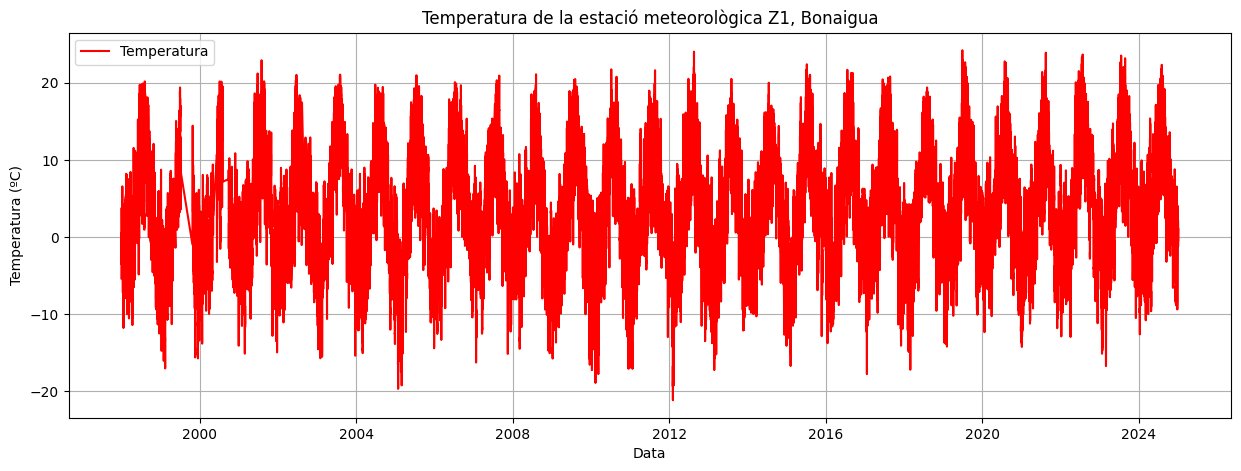

In [4]:
# Plot de les dades de temperatura de tota la serie temporal
plt.figure(figsize=(15, 5))
plt.plot(df_agrupades['data'], df_agrupades['valor'], label='Temperatura', color = 'red')
plt.title('Temperatura de la estació meteorològica Z1, Bonaigua')
plt.xlabel('Data')
plt.ylabel('Temperatura (ºC)')
plt.legend()
plt.grid()
plt.show()


# Construcció model ARIMA

In [23]:
# Construccio model ARIMA

data = df_agrupades.copy()
# data.set_index('data', inplace=True)
# Covnertim a datatime els index si no ho estan
# data.index = pd.to_datetime(data.index)
data.head(10)

,data,valor
0,1998-01-01 00:00:00+00:00,-5.38
1,1998-01-01 06:00:00+00:00,-4.73
2,1998-01-01 12:00:00+00:00,-1.98
3,1998-01-01 18:00:00+00:00,-1.80
4,1998-01-02 00:00:00+00:00,-2.07
5,1998-01-02 06:00:00+00:00,1.02
6,1998-01-02 12:00:00+00:00,-1.62
7,1998-01-02 18:00:00+00:00,-3.53
8,1998-01-03 00:00:00+00:00,-2.18
9,1998-01-03 06:00:00+00:00,2.15


In [25]:
# Definim els paràmetres p, d i q
p = 5*4  # Ordre de l'auto-regressió
d = 1  # Ordre de la diferenciació
q = 5  # Ordre de la mitjana mòbil


# Assignem per entrenar el model les dades fins el 2020, fem servir separador anual
# Fins el 2020 (inclòs) entrenarem el model, del 2021 fins final, que es 2024 (inclòs) farem el test

# Assignem data límit pel dataframe de train i pel de test. Ho fem en el format datetime
data_tall1 = pd.to_datetime('2020-12-31 23:59:59+00:00')
data_tall2 = pd.to_datetime('2021-01-01 00:00:00+00:00')


# Assignem el conjunt de train
data_train = data[data['data'] <= data_tall1]
# data_train.index = pd.to_datetime(data_train.index)

# Assignem el conjunt de test
data_test = data[data['data'] > data_tall2]


# Afegim 20 dades del conjunt de train al conjunt de test per iniciar la predicció
data_test = pd.concat([data_train[-p:], data_test])
data_test['data'].sort_values()

# data_test = data_test.sort_index()
# # data_test.index = pd.to_datetime(data_test.index)

data_test



,data,valor
32509,2020-12-27 00:00:00+00:00,-3.85
32510,2020-12-27 06:00:00+00:00,-1.18
32511,2020-12-27 12:00:00+00:00,0.88
32512,2020-12-27 18:00:00+00:00,-2.24
32513,2020-12-28 00:00:00+00:00,-6.02
...,...,...
38368,2024-12-30 18:00:00+00:00,0.03
38369,2024-12-31 00:00:00+00:00,-1.22
38370,2024-12-31 06:00:00+00:00,0.08
38371,2024-12-31 12:00:00+00:00,1.16


In [26]:
# Creem el model ARIMA
model = ARIMA(data_train['valor'], order=(p, d, q))

# Ajustem el model
model = model.fit()

# Mostrem el resum del model ajustat
print(model.summary())


                               SARIMAX Results                                
Dep. Variable:                  valor   No. Observations:                32529
Model:                ARIMA(20, 1, 5)   Log Likelihood              -61342.926
Date:                Wed, 09 Apr 2025   AIC                         122737.852
Time:                        09:44:46   BIC                         122955.988
Sample:                             0   HQIC                        122807.575
                              - 32529                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0590      0.144      0.408      0.683      -0.224       0.342
ar.L2         -0.1282      0.034     -3.761      0.000      -0.195      -0.061
ar.L3          0.0324      0.026      1.247      0.2

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Try small values manually
for p in range(0, 5):
    for q in range(0, 5):
        try:
            model = ARIMA(train, order=(p, 1, q))
            results = model.fit()
            print(f'ARIMA({p},1,{q}) AIC: {results.aic:.2f}')
        except:
            continue

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [9]:
# Guardem el model ajustat
model.save('model_arima.pkl')

In [48]:
# Carreguem el model ajustat
from statsmodels.tsa.arima.model import ARIMAResults
model = ARIMAResults.load('model_arima.pkl')

In [20]:
data_test.head(10)

,data,valor
32509,2020-12-27 00:00:00+00:00,-3.85
32510,2020-12-27 06:00:00+00:00,-1.18
32511,2020-12-27 12:00:00+00:00,0.88
32512,2020-12-27 18:00:00+00:00,-2.24
32513,2020-12-28 00:00:00+00:00,-6.02
32514,2020-12-28 06:00:00+00:00,-8.62
32515,2020-12-28 12:00:00+00:00,-7.02
32516,2020-12-28 18:00:00+00:00,-6.40
32517,2020-12-29 00:00:00+00:00,-8.18
32518,2020-12-29 06:00:00+00:00,-8.34


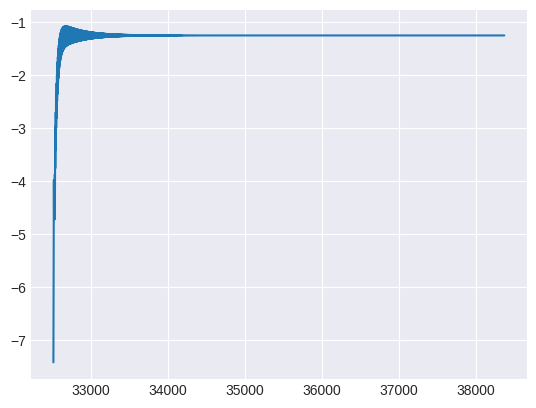

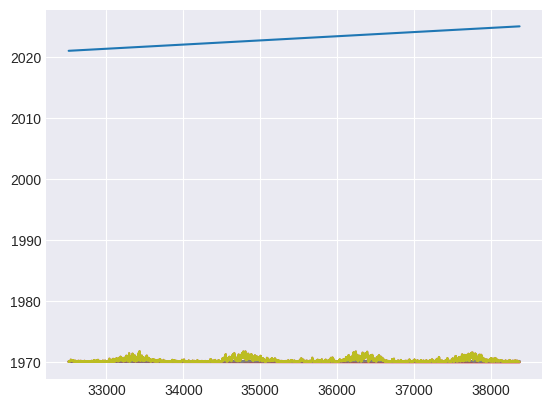

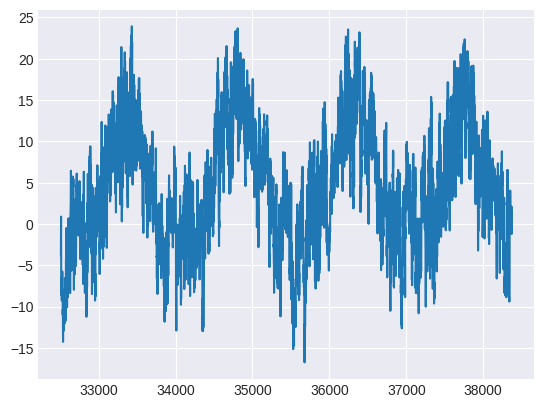

,data,valor,predicted_values,predicted_lower,predicted_upper,error,error_squared,error_absolute,error_absolute_squared
32509,2020-12-27 00:00:00+00:00,-3.85,-7.43,-10.55,-4.30,3.58,12.80,3.58,12.80
32510,2020-12-27 06:00:00+00:00,-1.18,-6.66,-11.45,-1.88,5.48,30.03,5.48,30.03
32511,2020-12-27 12:00:00+00:00,0.88,-5.31,-11.06,0.45,6.19,38.33,6.19,38.33
32512,2020-12-27 18:00:00+00:00,-2.24,-4.91,-11.42,1.61,2.67,7.11,2.67,7.11
32513,2020-12-28 00:00:00+00:00,-6.02,-4.86,-12.17,2.45,-1.17,1.36,1.17,1.36
32514,2020-12-28 06:00:00+00:00,-8.62,-4.54,-12.42,3.33,-4.08,16.65,4.08,16.65
32515,2020-12-28 12:00:00+00:00,-7.02,-3.99,-12.23,4.25,-3.04,9.22,3.04,9.22
32516,2020-12-28 18:00:00+00:00,-6.40,-4.33,-12.84,4.17,-2.07,4.27,2.07,4.27
32517,2020-12-29 00:00:00+00:00,-8.18,-4.63,-13.42,4.16,-3.55,12.64,3.55,12.64
32518,2020-12-29 06:00:00+00:00,-8.34,-4.42,-13.42,4.58,-3.92,15.35,3.92,15.35


In [22]:
# Predicció de tota la serie temporal

# Realitzem la predicció 
# Funcio get_prediction() retorna un objecte PredictionResults on tambe s'inclouen els intervals de confiança i altres estadístiques
# Si nomes volguessim la predicció, podríem utilitzar la funció predict() que retorna un array amb les prediccions

# Realitzem la predicció utilitzant get_prediction() que inclou els intervals de confiança
# data_test.index = pd.to_datetime(data_test.index)
start_date = data_test.index[0]  # Primer registre del conjunt de test
end_date = data_test.index[-1]  # Últim registre del conjunt de test



# Realitzem la predicció
predictions = model.get_prediction(start=start_date, end=end_date, dynamic=True)

# Obtenim les prediccions i els intervals de confiança
predicted_value = predictions.predicted_mean  # Prediccions puntuals
conf_int = predictions.conf_int()  # Intervals de confiança

# Afegim les prediccions al DataFrame de test
data_test['predicted_values'] = predicted_value
data_test['predicted_lower'] = conf_int['lower valor']  # Interval inferior
data_test['predicted_upper'] = conf_int['upper valor']  # Interval superior

# Afegim les columnes d'error
data_test['error'] = data_test['valor'] - data_test['predicted_values']
data_test['error_squared'] = data_test['error'] ** 2
data_test['error_absolute'] = data_test['error'].abs()
data_test['error_absolute_squared'] = data_test['error_absolute'] ** 2

# # Mostrem les primeres files del dataframe amb les prediccions
data_test.head(10)


In [14]:
data_test.sample(10)

,data,valor,predicted_values,predicted_lower,predicted_upper,error,error_squared,error_absolute,error_absolute_squared
32857,2021-03-24 00:00:00+00:00,-0.55,-1.36,-16.39,13.67,0.81,0.65,0.81,0.65
32509,2020-12-27 00:00:00+00:00,-3.85,-7.43,-10.55,-4.30,3.58,12.80,3.58,12.80
36998,2024-01-23 06:00:00+00:00,3.61,-1.26,-37.41,34.89,4.87,23.70,4.87,23.70
33179,2021-06-12 12:00:00+00:00,13.36,-1.23,-18.84,16.38,14.59,212.78,14.59,212.78
34461,2022-04-29 00:00:00+00:00,2.39,-1.26,-26.65,24.13,3.65,13.33,3.65,13.33
36090,2023-06-10 06:00:00+00:00,10.56,-1.26,-33.97,31.45,11.82,139.67,11.82,139.67
34351,2022-04-01 12:00:00+00:00,-11.43,-1.26,-26.08,23.56,-10.17,103.51,10.17,103.51
36815,2023-12-08 12:00:00+00:00,-3.59,-1.26,-36.74,34.22,-2.33,5.44,2.33,5.44
35493,2023-01-12 00:00:00+00:00,-4.80,-1.26,-31.49,28.97,-3.54,12.53,3.54,12.53
33959,2021-12-24 12:00:00+00:00,1.17,-1.26,-23.92,21.41,2.42,5.88,2.42,5.88


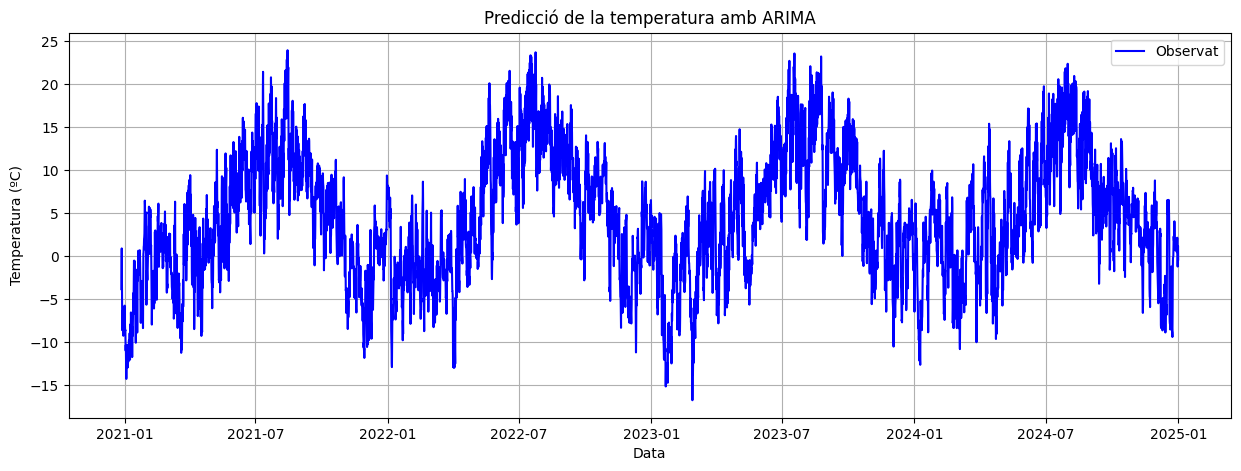

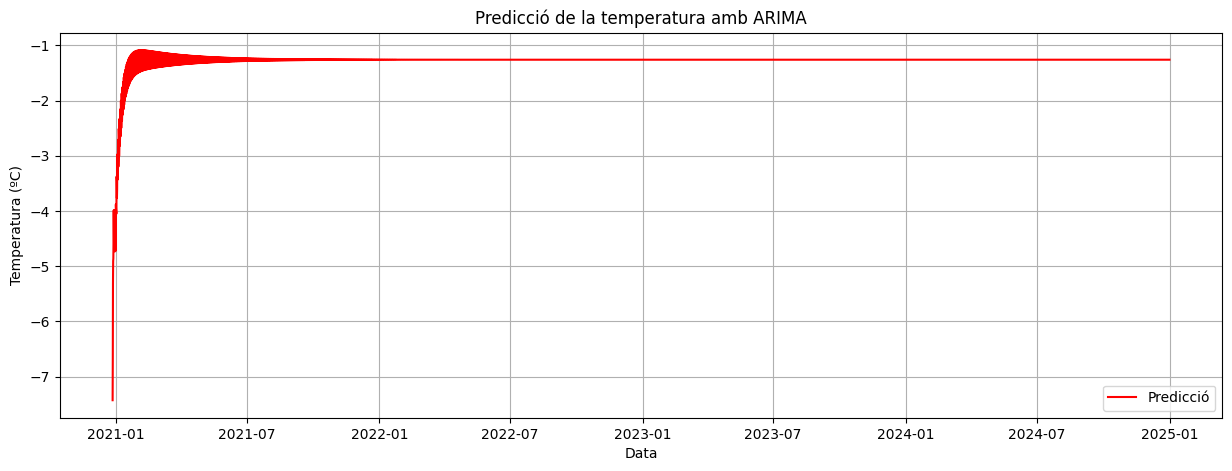

In [15]:

# Plotem els resultats
plt.figure(figsize=(15, 5))
# plt.plot(data_test['valor'], label='Observat', color='blue')
plt.plot(data_test['data'], data_test['valor'], label='Observat', color='blue')
plt.title('Predicció de la temperatura amb ARIMA')
plt.xlabel('Data')
plt.ylabel('Temperatura (ºC)')
plt.legend()
plt.grid()
plt.show()


# Plot predicció

plt.figure(figsize=(15, 5))
plt.plot(data_test['data'], data_test['predicted_values'], label='Predicció', color='red')
plt.title('Predicció de la temperatura amb ARIMA')
plt.xlabel('Data')
plt.ylabel('Temperatura (ºC)')
plt.legend()
plt.grid()
plt.show()


KeyError: '2021'

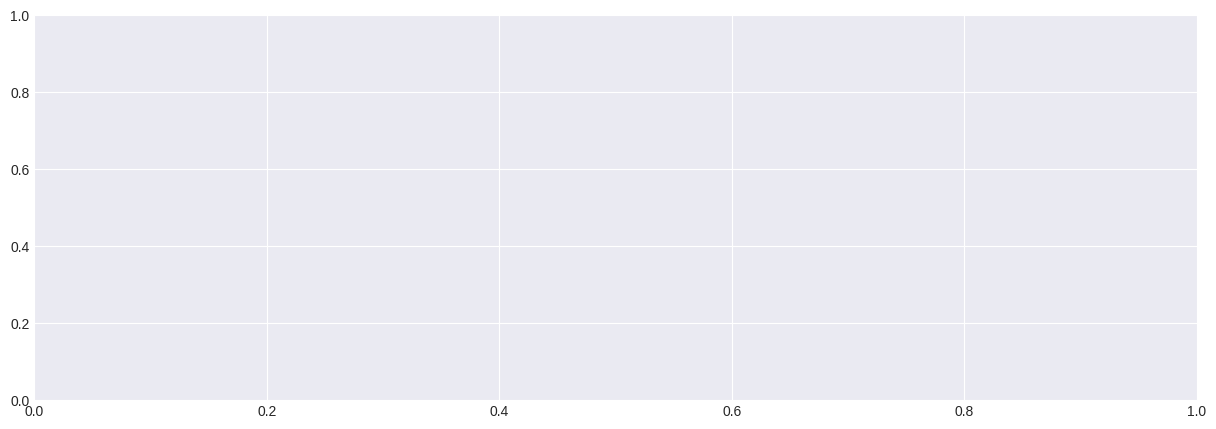

In [16]:
# Mateix plot pero ens fixem nomes en 2015

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

any = '2021'

plt.style.use("seaborn-v0_8-darkgrid")  # Millora l'estil del gràfic

fig, ax = plt.subplots(figsize=(15, 5))

# Gràfica de dades observades
ax.plot(data['valor'][any], label='Observat', color='#1f77b4', linewidth=2, alpha=0.8)

# Gràfica de la predicció
ax.plot(predicted_value[any], label='Predicció', color='#d62728', linestyle='dashed', linewidth=2)

# Gràfica de l'interval de confiança
# ax.fill_between(data.index[any], data['predicted_lower'][any],data['predicted_upper'][any], color='gray', alpha=0.2, label='Interval de confiança')


# Format de la graella i de les dates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Format curt de mes i any
plt.xticks(rotation=45)

# Etiquetes i títol
plt.title(f'Predicció de la temperatura amb ARIMA {any}', fontsize=14, fontweight='bold')
plt.xlabel('Data', fontsize=12)
plt.ylabel('Temperatura (ºC)', fontsize=12)

# Llegenda i grid
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()


In [ ]:
# Valorem el RMSE i MAE
# Calcula el RMSE
rmse = np.sqrt(mean_squared_error(data['valor'], predicted_value))
print('RMSE:', rmse)

# Calcula el MAE
mae = mean_absolute_error(data['valor'], predicted_value)
print('MAE:', mae)

# Calcula el MSE
mse = mean_squared_error(data['valor'], predicted_value)
print('MSE:', mse)


In [ ]:
# Plot dels errors
plt.figure(figsize=(15, 5))
plt.plot(data['error'], label='Error', color='red')
plt.title('Error de la predicció')
plt.xlabel('Data')
plt.ylabel('Error (ºC)')
# plt.xlim('Jan 01 2022', 'Dec 31 2022')
plt.legend()
plt.grid()
plt.show()



In [ ]:
# Predir del 2025 fins al març del 2026
# Definim el rang de dates per a la predicció amb el mateix format que el dataframe original
start_date = '2025-01-01'
end_date = '2026-03-31'

# Convertim les dates a datetime
start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)

# Realitzem la predicció
predictions_future = model.get_prediction(start=start_date, end=end_date, dynamic=False)

